# **Case Study: Grocery Recommendation System**

---------------
## **Context**
---------------
Online grocery platforms like Amazon have plenty of grocery data in their repository and if we can build a Recommendation System to recommend relevant grocery products to users, based on their historical interactions, this would improve customer satisfaction and hence, it will also improve the revenue of the platform. The techniques that we will use here will not only be limited to grocery, it can be any item for which you want to build a recommendation system..

-----------------
## **Objective**
-----------------

In this case study, we will build four types of recommendation systems: 
- **Knowledge/Rank Based recommendation system**
- **Similarity-Based Collaborative filtering**
- **Matrix Factorization Based Collaborative Filtering**
- **Clustering based recommendation system**


-----------------
## **Dataset**
-----------------

Out of many attributes available in the grocery dataset, we will only use the following four attributes:
- User_id
- Rating
- product_id
- Timestamp

## **Importing the necessary libraries and overview of the dataset**

In [229]:
# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np, pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in sklearn
from sklearn.metrics import mean_squared_error

In [230]:
pip install numpy==1.19.5

Note: you may need to restart the kernel to use updated packages.


### **Loading the data**

In [231]:
# Load the data again treating the first row as data
rating= pd.read_csv('ratings_Grocery_and_Gourmet_Food.csv', header=None, names=['UserID', 'ProductID', 'Rating', 'Timestamp'])

# Display the first few rows of the dataframe with proper headers
rating.head()


,UserID,ProductID,Rating,Timestamp
0,A1ZQZ8RJS1XVTX,0657745316,5.0,1381449600
1,A31W38VGZAUUM4,0700026444,5.0,1354752000
2,A3I0AV0UJX5OH0,1403796890,1.0,1385942400
3,A3QAAOLIXKV383,1403796890,3.0,1307836800
4,AB1A5EGHHVA9M,141278509X,5.0,1332547200


In [310]:
# Dropping the "ProductID" column
data = rating.drop("Timestamp", axis = 1)

Let's check the **info** of the data.

In [311]:
# This method is used to get the info of the dataframe.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297156 entries, 0 to 1297155
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   UserID     1297156 non-null  object 
 1   ProductID  1297156 non-null  object 
 2   Rating     1297156 non-null  float64
dtypes: float64(1), object(2)
memory usage: 29.7+ MB


- There are **1297156 rows** and **3 columns** in the data.

## **Data Exploration**

Let's start with the data exploration.

**We will first see the first five records of the movie dataset.**

In [312]:
# The head method is used to display the first five records of the dataset
data.head()

,UserID,ProductID,Rating
0,A1ZQZ8RJS1XVTX,0657745316,5.0
1,A31W38VGZAUUM4,0700026444,5.0
2,A3I0AV0UJX5OH0,1403796890,1.0
3,A3QAAOLIXKV383,1403796890,3.0
4,AB1A5EGHHVA9M,141278509X,5.0


#### **Describe the distribution of ratings**

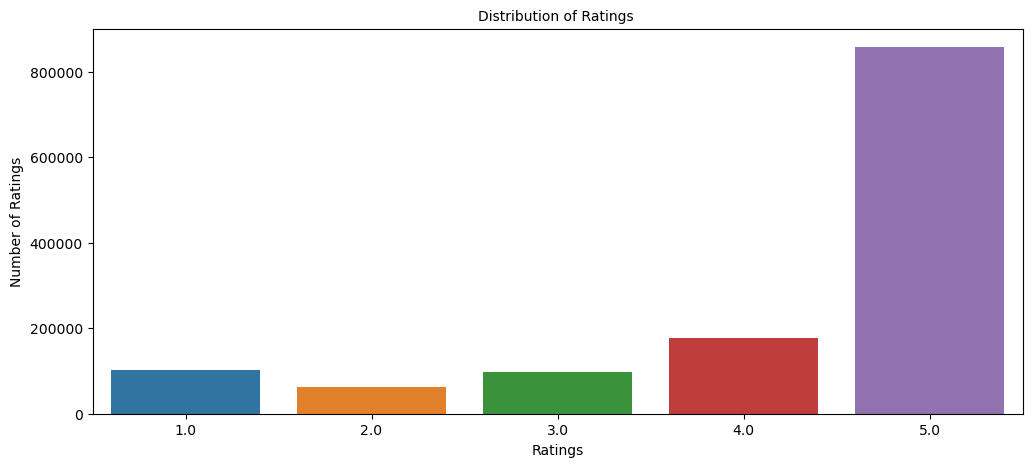

In [313]:
# Fix the figure size
plt.figure(figsize = (12, 5))

ax = sns.countplot(x = "Rating", data = data)

plt.tick_params(labelsize = 10)

plt.title("Distribution of Ratings ", fontsize = 10)

# Set the xlabel of the plot
plt.xlabel("Ratings", fontsize = 10)

# Set the ylabel of the plot
plt.ylabel("Number of Ratings", fontsize = 10)

# Display the plot
plt.show()

**Observations:**

* The data seems to be **highly skewed** towards Rating  **'5' and '4'**. Rating **'2'** is the lowest in the count and rating 5 is the highest. 

* We can see very few people are giving ratings **between 1 to 3**. It shows people tend to **not give a rating** for a grocery product  they **don't like**.

##### **What is the total number of unique users and unique movies**?

In [314]:
# Number of unique users
data['UserID'].nunique()

768438

In [315]:
# Number of unique ProductID
data['ProductID'].nunique()

166049

**Observations:**
- There are **768438 unique users** in the dataset.
- There are **166049 unique products** in the dataset.


#### **Is there any product that has been bought more than once by the same user?**

In [316]:
# Find the sum of total ratings count by each user product pair
data.groupby(['UserID', 'ProductID']).count()['Rating'].sum()

1297156

- The **sum is equal to the total number of observations** which implies **there is only interaction between a pair of products and a user**.

#### **Which products is the most bought product in the dataset?**

In [317]:
data['ProductID'].value_counts()

B0051SU0OW    6340
B00DS842HS    3755
B000E1D7RS    3102
B0029XDZIK    3011
B005K4Q1YA    3000
              ... 
B004I1TB5M       1
B004I1RFJG       1
B004I1RFBY       1
B004I1QPHE       1
B00LQWKDBM       1
Name: ProductID, Length: 166049, dtype: int64

**Observations:**
- The **product with productid B0051SU0OW has been interacted by most users** which is **6340** times.
- But still, there is a possibility of ** 1297156-6340 = 1290816** more interactions as we have **768438** unique users in our dataset. For those  **remaining users**, we can build a **recommendation system** to predict who is most likely to watch a movie.

Also, out of these **6340 interactions**, we need to consider the distribution of ratings as well to check whether this product is the **most liked or most disliked products**.

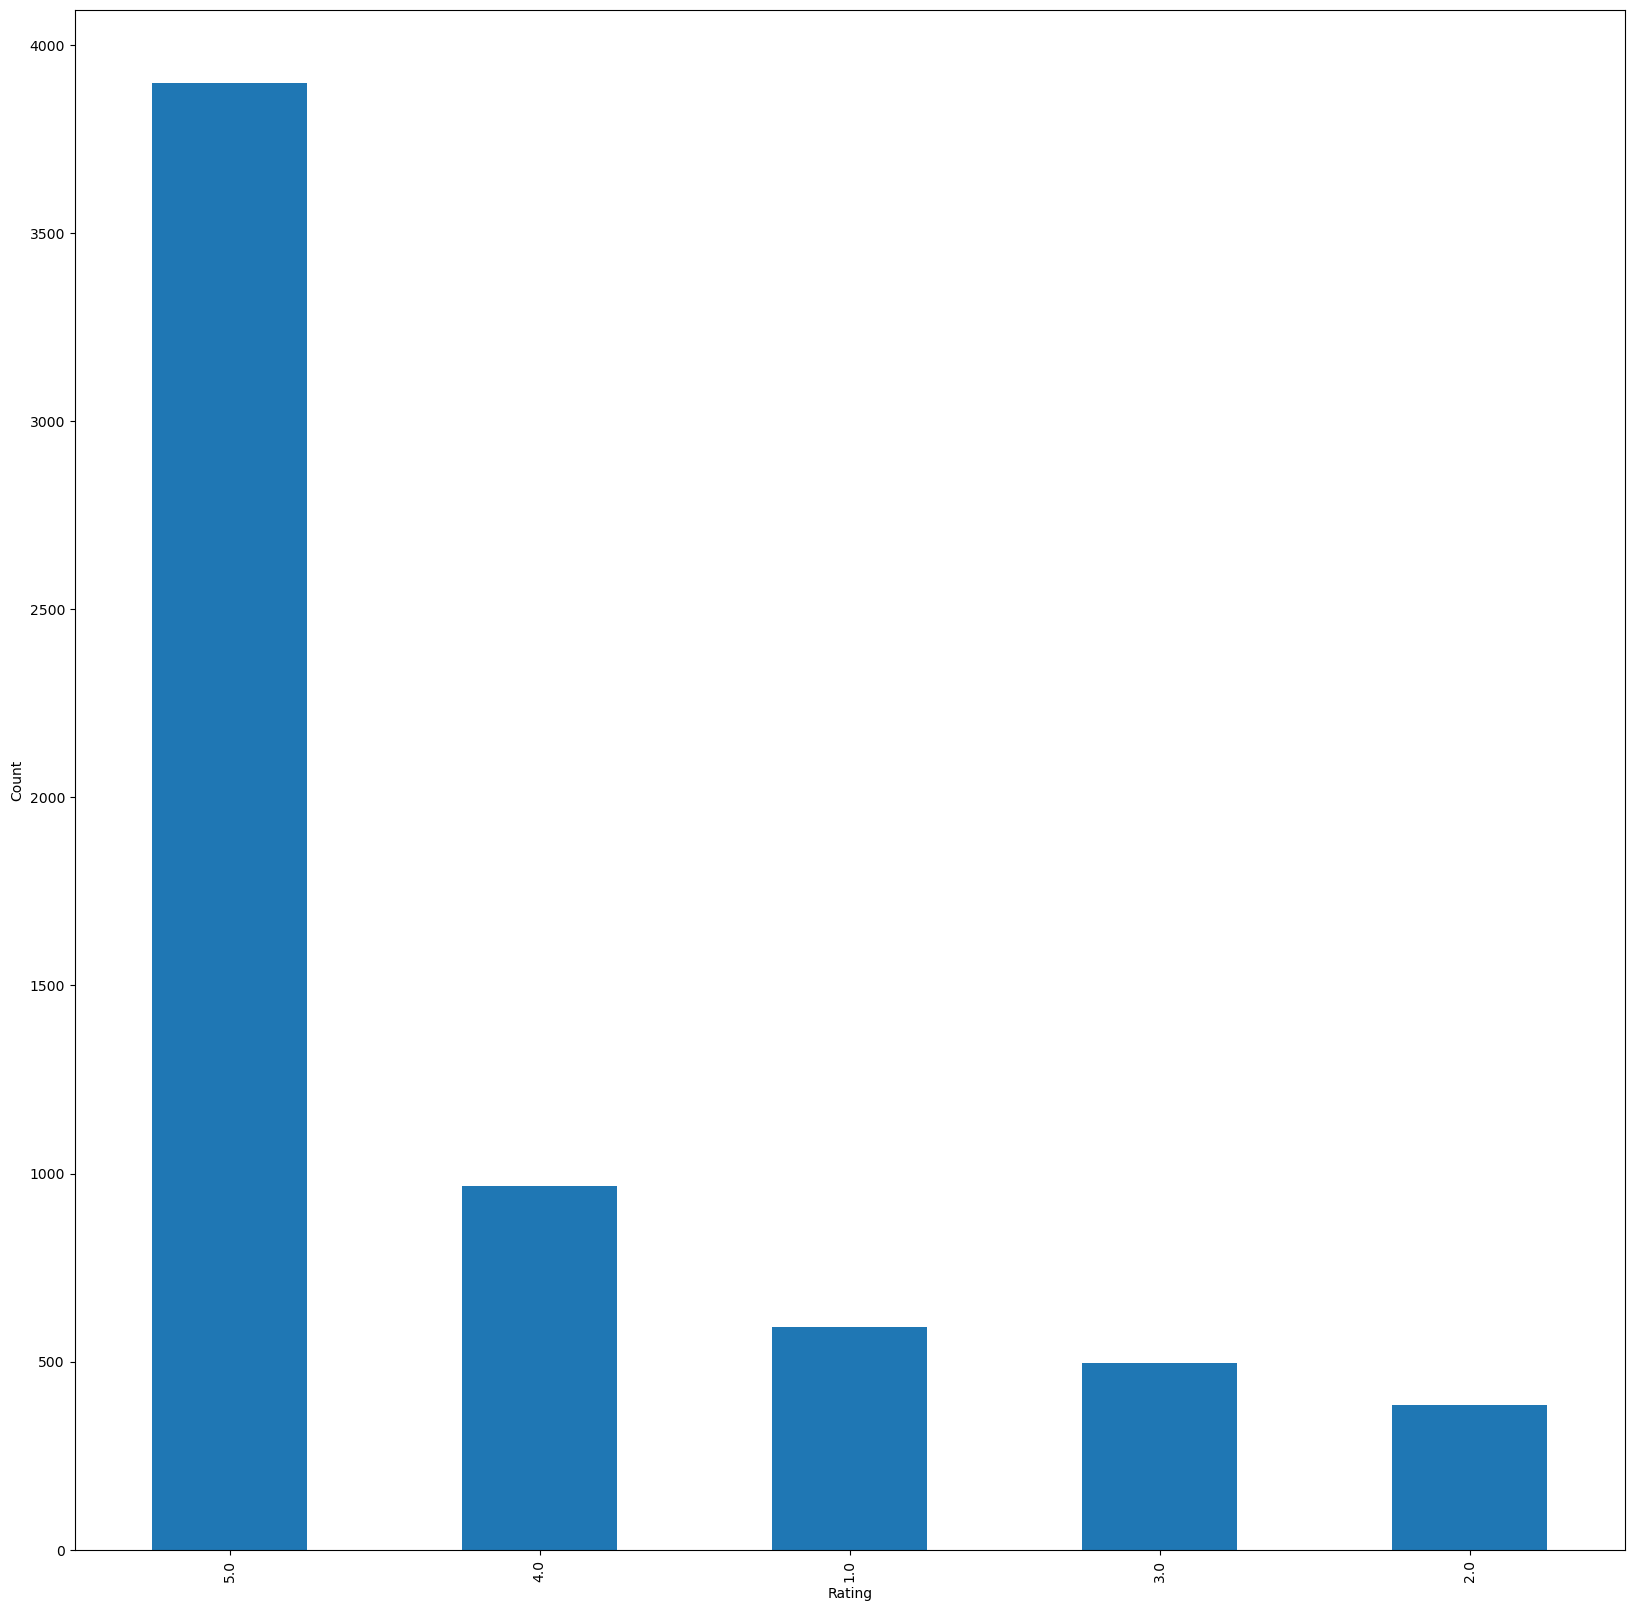

In [318]:
# Plotting distributions of ratings for 6340 interactions with given productid
plt.figure(figsize = (20, 20))

data[data['ProductID'] == "B0051SU0OW"]['Rating'].value_counts().plot(kind = 'bar')

# Name the xlabel of the plot
plt.xlabel('Rating')

# Name the ylabel of the plot
plt.ylabel('Count')

# Display the plot
plt.show()

**Observations:**
- We can see that **this product is liked by many of the users**, as the count of ratings 5 and 4 is higher than the count of other ratings.
- There can be products with very high interactions but the count of ratings **1 and 2** may be much higher than **4 or 5** which would imply that the product is disliked by the majority of the users.

#### **Which user bought the most to any product in the dataset?**

In [319]:
data['UserID'].value_counts()

AY12DBB0U420B     518
A1LACH6MLQWZ      490
A3D6OI36USYOU1    440
A2NYK9KWFMJV4Y    432
A3OXHLG6DIBRW8    378
                 ... 
A1V5V6MZRZ07VV      1
A88N2G7PL3PKV       1
A3UGD9IW68R14Y      1
A1MT85CBISDLF3      1
A2NSZZ7Y0RAE45      1
Name: UserID, Length: 768438, dtype: int64

**Observations:**
- The user with **userid  AY12DBB0U420B  ** has interacted with the most number of Product, i.e., **518** times. 
- But still, there is a possibility of ** 768,438-518 =  767,920** more interactions as we have **768,438 unique product** in our dataset. For those **767,920** remaining products, we can build a recommendation system to predict which products are most likely to be reviewed by this user.

**As this dataset is very large and has 12,971,56  observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very less users. Hence we can reduce the dataset by considering certain Logical assumptions.**

Here, We will be taking users who have given at least 100 ratings, as we prefer to have some number of ratings of a products. 

In [320]:
# Get the column containing the users
users = data.UserID

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1   

In [321]:
# We want our users to have at least 100 ratings to be considered
RATINGS_CUTOFF = 100

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df_final = data.loc[ ~ data.UserID.isin(remove_users)]

**As we have now explored the data, let's start building the Recommendation systems**

## Model 1: **Building Rank-Based Recommendation System**

Rank-based recommendation system provides recommendations based on the most popular items. This kind of recommendation system is useful when we have **cold start** problems. Cold start refers to the issue when **we get a new user into the system** and the machine is not able to recommend grocery product to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use a rank-based recommendation system to recommend a product to the new user.

To build the rank-based recommendation system, we take the **average** of all the ratings provided to each product and then rank them based on their average rating.

In [322]:
# Calculating average ratings
average_rating = data.groupby('ProductID').mean()['Rating']

# Calculating the count of ratings
count_rating = data.groupby('ProductID').count()['Rating']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

In [323]:
# Let us see the first 5 records of the final_rating
final_rating.head()

,avg_rating,rating_count
ProductID,,
0657745316,5.0,1
0700026444,5.0,1
1403796890,2.0,2
141278509X,5.0,1
1453060375,1.0,1


Now, let's create a function to find the **top n product** for a recommendation based on the average ratings of the product. We can also add a **threshold for a minimum number of bought** for a product to be considered for recommendation. 

In [324]:
def top_n_product(data, n, min_interaction = 100):
    
    # Finding restautants with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    
    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get product to recommend.

#### **Recommending top 5 product with 50 minimum interactions based on popularity.**

In [325]:
list(top_n_product(final_rating, 5, 50))

['B000E1FZ78', 'B00FQU5S1K', 'B0029K5HIE', 'B000LEQ0QS', 'B00FRQ08OK']

Now, that we have seen **how to apply the Rank-Based Recommendation System**, let's apply the **Collaborative Filtering Based Recommendation System**.

## **Collaborative Filtering Based Recommendation System**.

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc.</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos.</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites.</li>
    <li><b>Reading</b> of articles by readers on various blogs.</li>
</ol>

#### Types of Collaborative Filtering

- Similarity/Neighborhood-based
 * User-User Similarity-Based  
 * Item-Item Similarity-based
- Model based

### **Building a baseline user-user similarity based recommendation system.**

- Below we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library - `surprise` to build the remaining models, let's first import the necessary classes and functions from this library.
- Please use the following code to `install the surprise` library. You only do it **once** while running the code for the first time.

**!pip install surprise**

In [326]:
!pip install surprise

In [327]:
# To compute the accuracy of models
from surprise import accuracy

# This class is used to parse a file containing ratings, data should be in structure - user; item; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's understand some basic terminologies we will be using here.**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating (here 3.0)** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold (here 3.0) is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.

**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which the company would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k and recall@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.

In [328]:
def precision_recall_at_k(model, k = 10, threshold = 3.0):
    """Returns precision and recall at k metrics for each user."""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant product
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended product in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant. When n_rec_k is 0, 
        # Precision is undefined. We here set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended. When n_rel is 0, 
        # Recall is undefined. We here set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)

    # Command to print the overall precision
    print('Precision: ', precision)

    # Command to print the overall recall
    print('Recall: ', recall)

    # Formula to compute the F-1 score
    print('F_1 score: ', round((2*precision * recall) / (precision + recall), 3))

Below we are loading the **dataset**, which is a **pandas dataframe**, into a **different format called `surprise.dataset.DatasetAutoFolds`** which is required by this library. To do this we will be **using the classes `Reader` and `Dataset`**.

In [329]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the dataset
data = Dataset.load_from_df(df_final[['UserID', 'ProductID', 'Rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

- Now we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.
- **KNNBasic** is an algorithm that is also **associated with the surprise package**, it is used to find the **desired similar items among a given set of items**.

- To compute **precision and recall**, a **threshold of 3.0 and k value of 10 is taken for the recommended and relevant ratings**. 
- In the **present case precision and recall both need to be optimized as the service provider would like to minimize both the losses discussed** above. Hence, the correct performance measure is the **F_1 score**. 

## Model 2: **Building User-User Collaborative Filtering Model**

In [330]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN algorithm is used to find desired similar items
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_user_user)

RMSE: 1.0419
Precision:  0.923
Recall:  0.366
F_1 score:  0.524


- We have calculated **RMSE** to check **how far the overall predicted ratings** are from the **actual ratings**.
- Intuition of Recall - We are getting a **recall of almost 0.36**, which means out of **all the relevant product, 36% are recommended**. 
- Intuition of Precision - We are getting a **precision of almost 0.923**, which means **out of all the recommended product 92.3% are relevant**.
- Here **F_1 score** of the **baseline model is almost 0.524**. It indicates that **mostly recommended products were relevant and relevant product were recommended** to the user. We will try to improve this later by using **GridSearchCV by tuning different hyperparameters** of this algorithm.

Let's now **predict rating for a user with `userId = B000E1D7RS` and `productid =0657745316 `** as shown below.

In [331]:
# Predicting rating for a sample user with a bought product
sim_user_user.predict("B000E1D7RS", "0657745316", r_ui = 5, verbose = True)

user: B000E1D7RS item: 0657745316 r_ui = 5.00   est = 4.36   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='B000E1D7RS', iid='0657745316', r_ui=5, est=4.361814046061984, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

- The above output shows that **the actual rating for this user-item pair is 5 and the predicted rating is 4.36** by the **user-user-similarity-based baseline model**. This implies that the model is under-estimating the ratings.

Below we are **predicting rating for the same `userId =A3QAAOLIXKV383		 ` but for a product which this user has not seen yet, i.e., `productid = 1403796890`** 

In [332]:
# Predicting rating for a sample user with a restaurant that is not-visited by the user
sim_user_user.predict("A3QAAOLIXKV383", "1403796890", verbose = True)

user: A3QAAOLIXKV383 item: 1403796890 r_ui = None   est = 4.36   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3QAAOLIXKV383', iid='1403796890', r_ui=None, est=4.361814046061984, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

- As we can see the estimated rating for this user-item pair is 4.36 based on this similarity based baseline model.

Now let's build the **final model by using tuned values of the hyperparameters** which we received by using **grid search cross-validation**.

In [333]:
# Using the optimal similarity measure for user-user-based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9955
Precision:  0.917
Recall:  0.365
F_1 score:  0.522


- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model has reduced a bit as compared to the baseline model.**

Let's us now **predict rating for a user with `userId` = "A1ZQZ8RJS1XVTX", and productid= "141278509X" with the optimized model as shown below**.

In [334]:
sim_user_user_optimized.predict("A1ZQZ8RJS1XVTX", "141278509X", r_ui = 5, verbose = True)

user: A1ZQZ8RJS1XVTX item: 141278509X r_ui = 5.00   est = 4.36   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A1ZQZ8RJS1XVTX', iid='141278509X', r_ui=5, est=4.361814046061984, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

Below we are predicting rating for the same **`userId = "A1ZQZ8RJS1XVTX"`** but for a product which this user has **not bought before**, i.e., `Productid =141278509X `, by using the **optimized model** as shown below - 

In [336]:
sim_user_user_optimized.predict("A1ZQZ8RJS1XVTX", "141278509X", verbose = True)

user: A1ZQZ8RJS1XVTX item: 141278509X r_ui = None   est = 4.36   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A1ZQZ8RJS1XVTX', iid='141278509X', r_ui=None, est=4.361814046061984, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below we are finding the 5 most similar users to the first user in the list with internal id 0.

In [337]:
# Here 0 is the internal id of the above user
sim_user_user_optimized.get_neighbors(0, 5)

[6, 10, 13, 15, 19]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are - 

- data: A **rating** dataset.
- user_id: A user id **for which we want the recommendations**.
- top_n: The **number of product we want to recommend**.
- algo: The algorithm we want to use **for predicting the ratings**.
- The output of the function is a **set of top_n product** recommended for the given user_id based on the given algorithm.

In [338]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot_table(index = 'UserID', columns = 'ProductID', values = 'Rating')
    
    # Extracting those restaurant ids which the user_id has not visited yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non bought product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    # Returing top n highest predicted rating product for this user
    return recommendations[:top_n]

#### **Predicted top 5 product for userId = "A2NYK9KWFMJV4Y" with similarity based recommendation system**

In [339]:
# Making top 5 recommendations for user_id "A1ZQZ8RJS1XVTX" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A2NYK9KWFMJV4Y", 5, sim_user_user)

In [340]:
# Building the dataframe for above recommendations with columns "ProductID" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['ProductID', 'predicted_ratings'])

,ProductID,predicted_ratings
0,9742356831,5
1,B0000531B7,5
2,B00006G92S,5
3,B0000C69FB,5
4,B0000CCZWH,5


### **Correcting the Ratings and Ranking the above products**

While comparing the ratings of two products, it is not only the **ratings** that describe the **likelihood of the user to that product**. Along with the rating the **number of users who have seen that product** also becomes important to consider. Due to this, we have calculated the **"corrected_ratings"** for each product. Commonly higher the **"rating_count" of a product more it is liked by users**. To interpret the above concept, a **product rated 4 by 3 people is less liked in comparison to a product rated 3 by 50 people**. It has been **empirically found that the likelihood of the product is directly proportional to the inverse of the square root of the rating_count of the product**.

In [341]:
def ranking_products(recommendations, final_rating):
    # Sort the products based on ratings count
    ranked_products = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending = False)[['rating_count']].reset_index()

    # Merge with the recommended businesses to get predicted ratings
    ranked_products = ranked_products.merge(pd.DataFrame(recommendations, columns = ['ProductID', 'predicted_ratings']), on = 'ProductID', how = 'inner')

    # Rank the businesses based on corrected ratings
    ranked_products['corrected_ratings'] = ranked_products['predicted_ratings'] - 1 / np.sqrt(ranked_products['rating_count'])

    # Sort the businesses based on corrected ratings
    ranked_products = ranked_products.sort_values('corrected_ratings', ascending = False)
    
    return ranked_products

**Note:** In the **above-corrected rating formula**, we can add the **quantity `1 / np.sqrt(n)` instead of subtracting it to get more optimistic predictions**. But here we are **subtracting this quantity**, as there are some products with ratings 5 and **we can't have a rating more than 5 for a product**.

In [342]:
# Applying the ranking products function and sorting it based on corrected ratings
ranking_products(recommendations, final_rating)

,ProductID,rating_count,predicted_ratings,corrected_ratings
0,B0000531B7,157,5,4.920191
1,9742356831,77,5,4.886039
2,B00006G92S,69,5,4.879614
3,B0000C69FB,36,5,4.833333
4,B0000CCZWH,4,5,4.500000


### Model 3: **Building Item Item Collaborative Filtering Model**

* Above we have seen **similarity-based collaborative filtering** where similarity has seen **between the users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between the items**. 

In [343]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 1.0319
Precision:  0.918
Recall:  0.364
F_1 score:  0.521


- The baseline model is giving an F_1 score of **about 52%**. We will try to **improve this later by using GridSearchCV** by tuning different hyperparameters of this algorithm.

Let's now **predict a rating for a user with `userId = A2NYK9KWFMJV4Y` and `productID = B0000C69FB`** as shown below. Here the user has already interacted or bought the product with productId "B0000C69FB".

In [344]:
# Predicting rating for a sample user with a bought product
sim_item_item.predict("A2NYK9KWFMJV4Y", "B0000C69FB", r_ui = 5, verbose = True)

user: A2NYK9KWFMJV4Y item: B0000C69FB r_ui = 5.00   est = 5.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A2NYK9KWFMJV4Y', iid='B0000C69FB', r_ui=5, est=5, details={'actual_k': 1, 'was_impossible': False})

Below we are **predicting rating for the same `userId = A2NYK9KWFMJV4Y` but for a restaurant which this user has not visited yet, i.e., `product_id = B0000C69FB`** 

In [345]:
# Predicting rating for a sample user with product not visited by the user
sim_item_item.predict("A2NYK9KWFMJV4Y", "B0000C69FB", verbose = True)

user: A2NYK9KWFMJV4Y item: B0000C69FB r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A2NYK9KWFMJV4Y', iid='B0000C69FB', r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False})

### **Improving similarity-based recommendation system by tuning its hyper-parameters**

Below we will be **tuning hyperparameters for the `KNNBasic` algorithms**.

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

In [346]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 9, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9999
Precision:  0.918
Recall:  0.364
F_1 score:  0.521


- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model is much better than the baseline model**. Also, there is a considerable fall in the RMSE value after tuning the hyperparameters. Hence the tuned model is doing better than the earlier one.

Let's us now predict **rating for an user with `userId = A2NYK9KWFMJV4Y` and for `business_id = B0000CCZWH	`** with the **optimized model** as shown below.

In [347]:
sim_item_item_optimized.predict("A2NYK9KWFMJV4Y", "B0000CCZWH", r_ui = 5, verbose = True)

user: A2NYK9KWFMJV4Y item: B0000CCZWH r_ui = 5.00   est = 4.36   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A2NYK9KWFMJV4Y', iid='B0000CCZWH', r_ui=5, est=4.361814046061984, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- Here the optimized model is predicting a good rating (almost **4.36**) for the product whose actual rating is 5. 

Below we are **predicting rating** for the same **`userId =A2NYK9KWFMJV4Y `** but for a product which this user **has not bought before**, i.e., `product ==B004I1RFBY `, by using the optimized model as shown below - 

In [348]:
sim_item_item_optimized.predict("A2NYK9KWFMJV4", "B004I1RFBk", verbose = True)

user: A2NYK9KWFMJV4 item: B004I1RFBk r_ui = None   est = 4.36   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A2NYK9KWFMJV4', iid='B004I1RFBk', r_ui=None, est=4.361814046061984, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

- For an unknown product the model is predicting a rating of **4.36**.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar product** to a given product or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding 5 most similar items to the items with internal id 0 based on the `msd` distance metric

In [349]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[23, 26, 48, 66, 130]

#### **Predicted top 5 product for userId = "	A3OXHLG6DIBRW8" with similarity based recommendation system.**

In [350]:
# Making top 5 recommendations for user_id rLtl8ZkDX5vH5nAx9C3q5Q with similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3OXHLG6DIBRW8", 5, sim_item_item_optimized)

In [351]:
# Building the dataframe for above recommendations with columns "business_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['ProductID', 'predicted_ratings'])

,ProductID,predicted_ratings
0,B001PAS5GK,4.992218
1,B001EPQQL2,4.850000
2,B004Z4HUXM,4.840580
3,B000HQKN6I,4.833333
4,B0046H312W,4.812500


In [352]:
# Applying the ranking_products function and sorting it based on corrected ratings
ranking_products(recommendations, final_rating)

,ProductID,rating_count,predicted_ratings,corrected_ratings
1,B001PAS5GK,42,4.992218,4.837915
0,B001EPQQL2,86,4.850000,4.742167
2,B004Z4HUXM,31,4.840580,4.660974
3,B0046H312W,27,4.812500,4.620050
4,B000HQKN6I,7,4.833333,4.455369


* Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### Model 4: **Building Model Based Collaborative Filtering Recommendation System - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### **Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item interaction matrix**. But SVD does not work when values are missing in the **user-item interaction matrix**.

### **Building a baseline matrix factorization recommendation system**

In [353]:
# Using SVD matrix factorization
svd = SVD(random_state = 1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Let us compute precision@k and recall@k with k = 10
precision_recall_at_k(svd)

RMSE: 0.9425
Precision:  0.922
Recall:  0.366
F_1 score:  0.524


- The baseline model with the algorithm is giving a nice F-1 score (almost **52%**). It indicates a good performance by the model.

Let's now predict the rating for a user with **`userId = "A2NYK9KWFMJV4Y"** and **`Product = "B0046H312W	"`** as shown below. Here the user has already rated..

In [354]:
# Making the prediction
svd.predict("A2NYK9KWFMJV4Y", "B0046H312W", r_ui = 5, verbose = True)

user: A2NYK9KWFMJV4Y item: B0046H312W r_ui = 5.00   est = 4.89   {'was_impossible': False}


Prediction(uid='A2NYK9KWFMJV4Y', iid='B0046H312W', r_ui=5, est=4.894954886554964, details={'was_impossible': False})

As we can see - **the actual rating** for this user-item pair is 5 and the predicted rating is also close to that. .

Below we are predicting rating for the same `userId = A2NYK9KWFMJV4Y` but for a restaurant which this user has not seen before, i.e., `product = B0046H312W`, as shown below - 

In [355]:
# Making prediction using the svd model
svd.predict("A2NYK9KWFMJV4Y", "B0046H312W", verbose = True)

user: A2NYK9KWFMJV4Y item: B0046H312W r_ui = None   est = 4.89   {'was_impossible': False}


Prediction(uid='A2NYK9KWFMJV4Y', iid='B0046H312W', r_ui=None, est=4.894954886554964, details={'was_impossible': False})

We can see that the **estimated rating** for this **user-item pair** is ~4.89 based on this **matrix factorization based baseline model**.

### **Improving matrix factorization-based recommendation system by tuning its hyper-parameters.**

In SVD, rating is predicted as - 

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Below we will be tuning only three hyperparameters -
- **n_epochs**: The number of iterations of the SVD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [356]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the model on the data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9386158983505329
{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters as shown above.

Now we will **build the final model** by using **tuned values** of the hyperparameters which we received by using grid search cross-validation.

In [357]:
# Building the optimized SVD model using optimal hyperparameter search
svd_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Training the algorithm on the trainset
svd_optimized = svd_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(svd_optimized)

RMSE: 0.9390
Precision:  0.929
Recall:  0.369
F_1 score:  0.528


- We can see from above that the **tuned model** is showing a slightly better F_1 score than the baseline model, also the RMSE has gone down. Hence the tuned model is doing better than the earlier model.

Let's now predict a rating for a user with `userId =A2NYK9KWFMJV4Y ` and `product =B0046H312W ` with the optimized model as shown below.

In [358]:
# Using svd_algo_optimized model to recommend for userId "A2NYK9KWFMJV4Y" and productid=B0046H312W
svd_optimized.predict("A2NYK9KWFMJV4Y", "B0046H312W", r_ui = 5, verbose = True)

user: A2NYK9KWFMJV4Y item: B0046H312W r_ui = 5.00   est = 4.88   {'was_impossible': False}


Prediction(uid='A2NYK9KWFMJV4Y', iid='B0046H312W', r_ui=5, est=4.878804555915107, details={'was_impossible': False})

- The predicted rating is good here for a product whose actual rating is **5**. The optimized model is giving a fairly good prediction.

In [359]:
# Using svd_optimized model to recommend for userId "A2NYK9KWFMJV4" and productid"9742356831" which the user has not visited
svd_optimized.predict("A2NYK9KWFMJV4", "9742356831", verbose = True)

user: A2NYK9KWFMJV4 item: 9742356831 r_ui = None   est = 4.47   {'was_impossible': False}


Prediction(uid='A2NYK9KWFMJV4', iid='9742356831', r_ui=None, est=4.47258802107314, details={'was_impossible': False})

- For an unseen product the rating given by the optimized model seems to be good. 

In [360]:
# Getting top 5 recommendations for user_id  A2NYK9KWFMJV4Y using "svd_optimized" algorithm
svd_recommendations = get_recommendations(df_final,"A2NYK9KWFMJV4Y", 5, svd_optimized)

In [361]:
pd.DataFrame(svd_recommendations, columns = ['ProductID', 'predicted_ratings'])

,ProductID,predicted_ratings
0,B0000CER6R,5
1,B0000DID5R,5
2,B0000DIRZR,5
3,B0000DIVUE,5
4,B0000DIYHO,5


In [362]:
# Ranking products based on above recommendations
ranking_products(svd_recommendations, final_rating)

,ProductID,rating_count,predicted_ratings,corrected_ratings
0,B0000DID5R,479,5,4.954309
1,B0000CER6R,5,5,4.552786
2,B0000DIVUE,3,5,4.422650
3,B0000DIYHO,2,5,4.292893
4,B0000DIRZR,1,5,4.000000


## Model 5: **Cluster-Based Recommendation System**

In **clustering-based recommendation systems**, we explore the **similarities and differences** in people's tastes in restaurants based on how they rate different restaurants. We cluster similar users together and recommend product to a user based on ratings from other users in the same cluster.

- **Co-clustering** is a set of techniques in **Cluster Analysis**. Given some **matrix A, we want to cluster rows of A and columns of A simultaneously**, this is a common task for user-item matrices. 

- As it clusters both the rows and columns simultaneously, it is also called **bi-clustering**. To understand the working of the algorithm let A be m x n matrix, goal is to generate co-clusters: a subset of rows that exhibit similar behavior across a subset of columns, or vice versa.

- Co-clustering is defined as two map functions:
rows -> row cluster indexes
columns -> column cluster indexes
These map functions are learned simultaneously. It is **different from other clustering techniques** where we cluster **first the rows and then the columns**. 

In [363]:
# Using Co-Clustering algorithm
clust_baseline = CoClustering(random_state = 1)

# Training the algorithm on the train set
clust_baseline.fit(trainset)

# Let us compute precision@k and recall@k with k = 10
precision_recall_at_k(clust_baseline)

RMSE: 1.0435
Precision:  0.93
Recall:  0.369
F_1 score:  0.528




* We have calculated **RMSE** to check **how far the overall predicted ratings** are from the **actual ratings**.

* Here **F_1 score** of the **baseline model is almost 0.528**. It indicates that **recommended restaurants were relevant and relevant restaurants were recommended for more than half the recommendations**. We will try to improve this later by using **GridSearchCV by tuning different hyperparameters** of this algorithm.

Let's now **predict a rating for a user with `userId = A2NYK9KWFMJV4Y `and product_Id' =B0000CER6R	`** as shown below. Here the user has already interacted or visited the Product with product "".

In [364]:
# Making prediction for user_id  and product
clust_baseline.predict("A2NYK9KWFMJV4Y", "B0000DIVUE", r_ui = 5, verbose = True)

user: A2NYK9KWFMJV4Y item: B0000DIVUE r_ui = 5.00   est = 5.00   {'was_impossible': False}


Prediction(uid='A2NYK9KWFMJV4Y', iid='B0000DIVUE', r_ui=5, est=5, details={'was_impossible': False})

- As we can see - the **actual rating** for this **user-item pair is 5** and the **predicted rating is 5 by this Co-clustering based baseline model**. .

Below we are **predicting rating for the same `userId =A2NYK9KWFMJV4Y ` but for a restaurant which this user has not visited yet, i.e., `productID = upd802286498`** 

In [365]:
# Making prediction for userid 4 and product upd802286498
clust_baseline.predict("A2NYK9KWFMJV4Y", "upd802286498", verbose = True)

user: A2NYK9KWFMJV4Y item: upd802286498 r_ui = None   est = 4.36   {'was_impossible': False}


Prediction(uid='A2NYK9KWFMJV4Y', iid='upd802286498', r_ui=None, est=4.361814046061984, details={'was_impossible': False})

- We can see that **estimated rating** for this user-item pair is 4.36 based on this Co-clustering based baseline model.

### **Improving clustering based recommendation system by tuning its hyper-parameters**

Below we will be tuning hyper-parameters for the `CoClustering` algorithms. Let's try to understand different hyperparameters of this algorithm.

- **n_cltr_u** (int) – Number of **user clusters**. The default value is 3.
- **n_cltr_i** (int) – Number of **item clusters**. The default value is 3.
- **n_epochs** (int) – Number of **iteration of the optimization loop**. The default value is 20.
- **random_state** (int, RandomState instance from NumPy, or None) – Determines the RNG that will be used for initialization. If int, random_state will be used as a seed for a new RNG. This is useful to get the same initialization over multiple calls to fit(). If RandomState instance, this same instance is used as RNG. If None, the current RNG from numpy is used. The default value is None.
- **verbose** (bool) – If True, the current epoch will be printed. The default value is False.

In [366]:
# Set the parameter space to tune
param_grid = {'n_cltr_u': [3, 4, 5, 6], 'n_cltr_i': [3, 4, 5, 6], 'n_epochs': [30, 40, 50]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(CoClustering, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0401300752777807
{'n_cltr_u': 4, 'n_cltr_i': 3, 'n_epochs': 40}


Once the grid search is **complete**, we can get the **optimal values** for each of those hyper-parameters as shown above.

Now we will build **final model** by using tuned values of the hyperparameters which we received by using grid search cross-validation.

In [367]:
# Using tuned Coclustering algorithm
clust_tuned = CoClustering(n_cltr_u = 3,n_cltr_i = 3, n_epochs = 40, random_state = 1)

# Training the algorithm on the train set
clust_tuned.fit(trainset)

# Let us compute precision@k and recall@k with k = 10
precision_recall_at_k(clust_tuned)

RMSE: 1.0435
Precision:  0.93
Recall:  0.369
F_1 score:  0.528


- We can see that the **F_1 score** for **tuned co-clustering model** on testset is **comparable with F_1 score** for baseline Co-clustering model. The model performance has not improved by much.

Let's now **predict a rating for a user with `userId = A2NYK9KWFMJV4Y` and `productID =B0000DIVUE	 `** as shown below. Here the user has already interacted or visited the restaurant with businessId "9yKzy9PApeiPPOUJEtnvkg".

In [368]:
# Making prediction for user_id  and product 
clust_tuned.predict("A2NYK9KWFMJV4Y", "B0000DIVUE", r_ui = 5, verbose = True)

user: A2NYK9KWFMJV4Y item: B0000DIVUE r_ui = 5.00   est = 5.00   {'was_impossible': False}


Prediction(uid='A2NYK9KWFMJV4Y', iid='B0000DIVUE', r_ui=5, est=5, details={'was_impossible': False})

- As we can see - the **actual rating** for this **user-item pair is 5** and the **predicted rating is 5 by this Co-clustering based baseline model*

Below we are **predicting rating for the same `userId =A2NYK9KWFMJV4Y ` but for a restaurant which this user has not visited yet, i.e., `productid = zp713qNhx8d9KCJJnrw1xA`** 

In [372]:
# Making prediction for userid  and productid
clust_tuned.predict("A2NYK9KWFMJV4Y", "zp713qNhx8d9KCJJnrw1xA", verbose = True)

user: A2NYK9KWFMJV4Y item: zp713qNhx8d9KCJJnrw1xA r_ui = None   est = 4.36   {'was_impossible': False}


Prediction(uid='A2NYK9KWFMJV4Y', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=4.361814046061984, details={'was_impossible': False})

In [373]:
# Getting top 5 recommendations for user_id 4 using "Co-clustering based optimized" algorithm
clustering_recommendations = get_recommendations(df_final, "A2NYK9KWFMJV4Y", 5, clust_tuned)

In [374]:
# Ranking product based on above recommendations
ranking_products(clustering_recommendations, final_rating)

,ProductID,rating_count,predicted_ratings,corrected_ratings
0,B0000531B7,157,5,4.920191
1,9742356831,77,5,4.886039
2,B00006G92S,69,5,4.879614
3,7800648702,4,5,4.500000
4,B0000691JF,3,5,4.422650


### **Conclusion**

In this case study, we built recommendation systems using five different algorithms. They are as follows:
- Rank-based using averages
- User-user-similarity-based collaborative filtering
- Item-item-similarity-based collaborative filtering
- model-based (matrix factorization) collaborative filtering
- Clustering based recommendation systems  

- We have seen how they are different from each other and what kind of data is needed to build each of these recommendation systems. We can further combine all the recommendation techniques we have seen.

- To demonstrate **"user-user-similarity-based collaborative filtering","item-item-similarity-based collaborative filtering", and "model-based (matrix factorization) collaborative filtering"**, **surprise** library has been introduced. For these algorithms **grid search cross-validation is applied to find the best working model**, and using that the **corresponding predictions are done**.

- **For performance evaluation** of these models **precision@k and recall@k** are introduced in this case study. Using these two metrics **F_1 score** is calculated for each working model.